In [69]:
import numpy as np
import pandas as pd
import json
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
import folium

In [70]:
res = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0] 

In [71]:
df = pd.read_html(str(table))[0]

In [72]:
df = df.loc[df['Borough'] != 'Not assigned',:]

In [73]:
df.reset_index(drop=True,inplace=True)

In [74]:
df.head(12)

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [75]:
df.shape

(103, 3)

## Get Coordinates 

In [76]:
coordinates = pd.read_csv('./Geospatial_Coordinates.csv')

In [77]:
df = df.join(coordinates.set_index('Postal Code'),on='Postal Code',how='inner')

In [78]:
df.head(12)

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


In [79]:
address = 'Toronto'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))


The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


### Create a map and markers


In [80]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)  
    
map_toronto

#### Define Foursquare Credentials and Version

In [81]:
CLIENT_ID = 'N5WIP1LRUNONK13GA2J003N1D1LLE2HWHGUDPLOPCPXNG1I3' # your Foursquare ID
CLIENT_SECRET = 'BI0T433A5KCX0LCMRNPT1HSJRSTXFCJC4VSQSOAYCBHC1MFM'  # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: N5WIP1LRUNONK13GA2J003N1D1LLE2HWHGUDPLOPCPXNG1I3
CLIENT_SECRET:BI0T433A5KCX0LCMRNPT1HSJRSTXFCJC4VSQSOAYCBHC1MFM


In [105]:
radius = 1000
LIMIT = 100
SPANISHID = '4bf58dd8d48988d150941735'
df['Spanish Restaurants'] = 0
for index, row in df.iterrows():
    
    lat = row['Latitude']
    long = row['Longitude']
    url = "https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&categoryId={}&radius={}&limit={}&v=20200401".format(
            CLIENT_ID,
            CLIENT_SECRET,
            lat,
            long,
            SPANISHID,
            radius,
            LIMIT)
    
    results = requests.get(url).json()['response']['venues']
    df.iloc[index,-1] = len(results)

In [107]:
df['Spanish Restaurants'].value_counts()

0     72
1     12
2      5
11     2
10     2
3      2
14     1
12     1
9      1
8      1
7      1
6      1
5      1
4      1
Name: Spanish Restaurants, dtype: int64

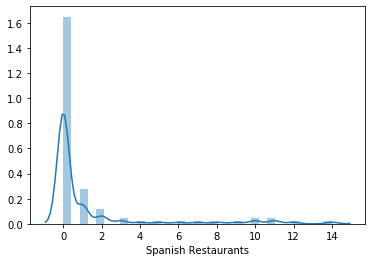

In [127]:
import seaborn as sns
ax = sns.distplot(df['Spanish Restaurants'])

### CLUSTERING

In [108]:
data = df[['Latitude','Longitude','Spanish Restaurants']]

In [110]:
from sklearn.preprocessing import StandardScaler
data_scaled = StandardScaler().fit_transform(data)

In [113]:
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(data_scaled)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 2, 2, 2, 2, 0, 0, 0, 1], dtype=int32)

In [114]:
df['Cluster'] = kmeans.labels_

### Visualizing the clusters

In [115]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, post, bor, poi, cluster in zip(df['Latitude'], df['Longitude'], df['Postal Code'], df['Borough'], df['Neighborhood'], df['Cluster']):
    label = folium.Popup('{} ({}): {} - Cluster {}'.format(bor, post, poi, cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Cluster 1

In [116]:
df.loc[df['Cluster'] == 0,:]

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Spanish Restaurants,Cluster
0,M3A,North York,Parkwoods,43.753259,-79.329656,0,0
1,M4A,North York,Victoria Village,43.725882,-79.315572,0,0
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,0,0
7,M3B,North York,Don Mills,43.745906,-79.352188,1,0
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,0,0
12,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,0,0
13,M3C,North York,Don Mills,43.725900,-79.340923,0,0
14,M4C,East York,Woodbine Heights,43.695344,-79.318389,1,0
18,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0,0
19,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,0


#### Cluster 2

In [117]:
df.loc[df['Cluster'] == 1,:]

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Spanish Restaurants,Cluster
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,6,1
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,7,1
24,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,8,1
30,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,12,1
36,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,5,1
37,M6J,West Toronto,"Little Portugal, Trinity",43.647927,-79.419750,10,1
42,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,11,1
48,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817,10,1
84,M5T,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",43.653206,-79.400049,14,1
92,M5W,Downtown Toronto,Stn A PO Boxes,43.646435,-79.374846,9,1


#### Cluster 3

In [118]:
df.loc[df['Cluster'] == 2,:]

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Spanish Restaurants,Cluster
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,3,2
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1,2
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,4,2
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242,0,2
10,M6B,North York,Glencairn,43.709577,-79.445073,0,2
11,M9B,Etobicoke,"West Deane Park, Princess Gardens, Martin Grov...",43.650943,-79.554724,0,2
16,M6C,York,Humewood-Cedarvale,43.693781,-79.428191,0,2
17,M9C,Etobicoke,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",43.643515,-79.577201,0,2
20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,3,2
21,M6E,York,Caledonia-Fairbanks,43.689026,-79.453512,1,2
